# House Price Prediction

### Author : Balu Niranjan

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("./train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Visualization

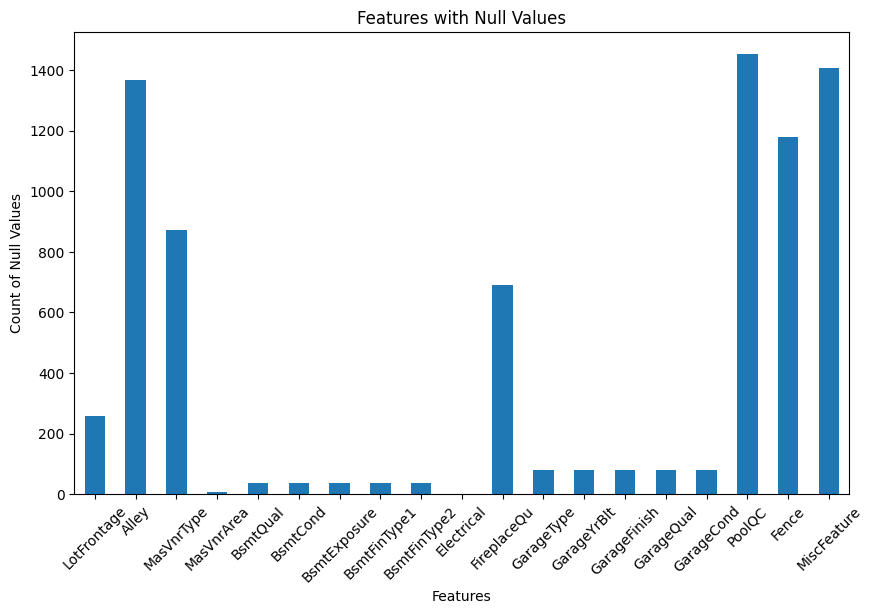

In [4]:
plt.figure(figsize=(10, 6))
null_counts = data.isnull().sum()
columns_with_nulls = null_counts[null_counts > 0]

columns_with_nulls.plot(kind='bar')

plt.xlabel('Features')
plt.ylabel('Count of Null Values')
plt.title('Features with Null Values')
plt.xticks(rotation=45)
plt.show()


<Axes: >

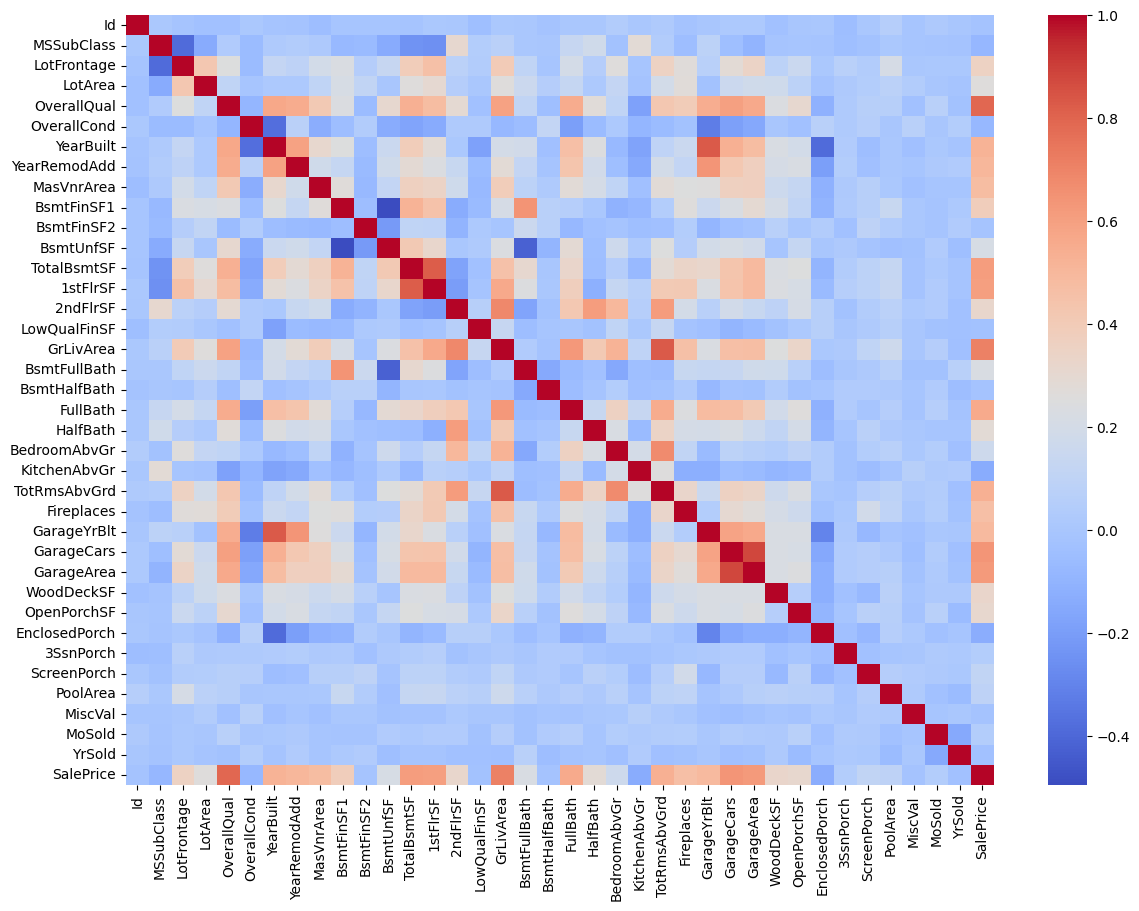

In [5]:
plt.figure(figsize=(14,10))
numeric_data = data.select_dtypes(include='number')
correlation_matrix = numeric_data.corr()

sns.heatmap(correlation_matrix, cmap='coolwarm')

## Data Preprocessing

In [6]:
df = data.drop(['Neighborhood','YrSold', 'YearRemodAdd', 'Exterior1st', 'Exterior2nd','RoofMatl','RoofStyle','MasVnrType','Foundation','Electrical','Heating','HeatingQC', 'LowQualFinSF', 'BsmtHalfBath', 'BsmtFinType1', 'BsmtFinType2', 'HalfBath', 'Functional','GarageType', 'GarageYrBlt','GarageQual','GarageCond', 'EnclosedPorch','3SsnPorch', 'Fence', 'MoSold', 'YrSold','SaleType'], axis=1)

### Imputing

In [7]:
for col in df:
    if data[col].dtype =='float64':
        print(col)

LotFrontage
MasVnrArea


In [8]:
df['LotFrontage'].isna().sum()

259

In [9]:
LotFrontageImp = SimpleImputer(missing_values=np.nan, strategy='median')
df['LotFrontage'] = LotFrontageImp.fit_transform(df[['LotFrontage']])

In [10]:
df['MasVnrArea'].isna().sum()

8

In [11]:
MasVnrAreaImp = SimpleImputer(missing_values=np.nan, strategy='median')
df['MasVnrArea'] = MasVnrAreaImp.fit_transform(df[['MasVnrArea']])

## Feature Engineering

In [12]:
transformers = []
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('None')
        x = df.groupby(col)['SalePrice'].median()
        cat = x.sort_values().index.tolist()
        encoder = OrdinalEncoder(categories=[cat], handle_unknown='use_encoded_value', unknown_value=-1)
        transformers.append((col, encoder, [col]))

In [13]:
transformers

[('MSZoning',
  OrdinalEncoder(categories=[['C (all)', 'RM', 'RH', 'RL', 'FV']],
                 handle_unknown='use_encoded_value', unknown_value=-1),
  ['MSZoning']),
 ('Street',
  OrdinalEncoder(categories=[['Grvl', 'Pave']],
                 handle_unknown='use_encoded_value', unknown_value=-1),
  ['Street']),
 ('Alley',
  OrdinalEncoder(categories=[['Grvl', 'None', 'Pave']],
                 handle_unknown='use_encoded_value', unknown_value=-1),
  ['Alley']),
 ('LotShape',
  OrdinalEncoder(categories=[['Reg', 'IR1', 'IR3', 'IR2']],
                 handle_unknown='use_encoded_value', unknown_value=-1),
  ['LotShape']),
 ('LandContour',
  OrdinalEncoder(categories=[['Bnk', 'Lvl', 'Low', 'HLS']],
                 handle_unknown='use_encoded_value', unknown_value=-1),
  ['LandContour']),
 ('Utilities',
  OrdinalEncoder(categories=[['NoSeWa', 'AllPub']],
                 handle_unknown='use_encoded_value', unknown_value=-1),
  ['Utilities']),
 ('LotConfig',
  OrdinalEncoder(categorie

In [14]:
X_proc = ColumnTransformer(transformers, remainder='passthrough')

In [15]:
X = X_proc.fit_transform(df)

In [16]:
col_names = X_proc.get_feature_names_out()
col_names =[x.split('__')[1] for x in col_names]

In [17]:
df_enc = pd.DataFrame(X, columns=col_names )

In [18]:
columns_to_drop = []

In [19]:
df_enc['Condition'] = df_enc['Condition1']+df_enc['Condition2']
columns_to_drop.append('Condition1')
columns_to_drop.append('Condition2')

In [20]:
df_enc['Exter'] = df_enc['ExterQual']+df_enc['ExterCond']
columns_to_drop.append('ExterQual')
columns_to_drop.append('ExterCond')

In [21]:
df_enc['Bsmt'] = df_enc['BsmtQual']+df_enc['BsmtCond']+df_enc['BsmtExposure']
columns_to_drop.append('BsmtQual')
columns_to_drop.append('BsmtCond')
columns_to_drop.append('BsmtExposure')

In [22]:
df_enc['Kitchen'] = df_enc['KitchenAbvGr']+df_enc['KitchenQual']
columns_to_drop.append('KitchenAbvGr')
columns_to_drop.append('KitchenQual')

In [23]:
df_enc.drop(columns_to_drop, axis=1, inplace=True)

## Scaling

In [24]:
scaler = StandardScaler()

column_to_exclude = 'SalePrice'
columns_to_scale = [col for col in df_enc.columns if col != column_to_exclude]
scaler.fit(df_enc[columns_to_scale])
data_scaled = scaler.transform(df_enc[columns_to_scale])
df_enc[columns_to_scale] = data_scaled

In [25]:
df_enc.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,BldgType,HouseStyle,...,WoodDeckSF,OpenPorchSF,ScreenPorch,PoolArea,MiscVal,SalePrice,Condition,Exter,Bsmt,Kitchen
0,0.359044,0.064238,0.024699,-0.657040,-0.111168,0.02618,-0.485795,-0.232549,0.131054,1.114326,...,-0.752176,0.216503,-0.270208,-0.068692,-0.087688,208500.0,0.137333,0.882620,-0.058157,0.66723
1,0.359044,0.064238,0.024699,-0.657040,-0.111168,0.02618,1.418260,-0.232549,0.131054,-0.177903,...,1.626195,-0.704483,-0.270208,-0.068692,-0.087688,181500.0,-1.951273,-0.136056,1.628783,-0.84309
2,0.359044,0.064238,0.024699,0.872909,-0.111168,0.02618,-0.485795,-0.232549,0.131054,1.114326,...,-0.752176,-0.070361,-0.270208,-0.068692,-0.087688,223500.0,0.137333,0.882620,0.504156,0.66723
3,0.359044,0.064238,0.024699,0.872909,-0.111168,0.02618,0.466233,-0.232549,0.131054,1.114326,...,-0.752176,-0.176048,-0.270208,-0.068692,-0.087688,140000.0,0.137333,-0.136056,-0.058157,0.66723
4,0.359044,0.064238,0.024699,0.872909,-0.111168,0.02618,1.418260,-0.232549,0.131054,1.114326,...,0.780197,0.563760,-0.270208,-0.068692,-0.087688,250000.0,0.137333,0.882620,1.066470,0.66723


## Modelling

### Simple Linear Regression

In [26]:
X = np.array(df_enc['OverallCond']).reshape(-1,1)
y = np.array(df_enc['SalePrice'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression()

In [27]:
print('Train',lr_model.score(X_train,y_train),'\nTest:',lr_model.score(X_test,y_test))

Train 0.0028776134555312805 
Test: 0.014505109125255822


### Multiple Linear Regression

In [28]:
mlr_model = LinearRegression()
X = np.array(df_enc.drop(['SalePrice'],axis=1))
y = np.array(df_enc['SalePrice'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

mlr_model.fit(X_train,y_train)

LinearRegression()

In [29]:
print('Train',mlr_model.score(X_train,y_train),'\nTest:',mlr_model.score(X_test,y_test))

Train 0.8594084494814456 
Test: 0.6417306217947532


### Polynomial Regression

In [30]:
degree=5
X = np.array(df_enc['OverallCond'])
y = np.array(df_enc['SalePrice'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())])

In [31]:
print('Train',polyreg.score(X_train,y_train),'\nTest:',polyreg.score(X_test,y_test))

Train 0.07951954745702416 
Test: 0.09515177060268931


### Regression Tree

In [32]:
X = np.array(df_enc.drop(['SalePrice'],axis=1))
y = np.array(df_enc['SalePrice'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = X_train
dt = DecisionTreeRegressor(max_depth=2)
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=2)

In [33]:
print('Train',dt.score(X_train,y_train),'\nTest:',dt.score(X_test,y_test))

Train 0.6398520698405806 
Test: 0.6102113509860625


### Random Forest Regression

In [34]:
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train,y_train)

RandomForestRegressor(random_state=0)

In [35]:
print('Train',rf.score(X_train,y_train),'\nTest:',rf.score(X_test,y_test))

Train 0.9800591701462581 
Test: 0.8292985367359422


#### Feature Importance

In [36]:
importance_scores = rf.feature_importances_

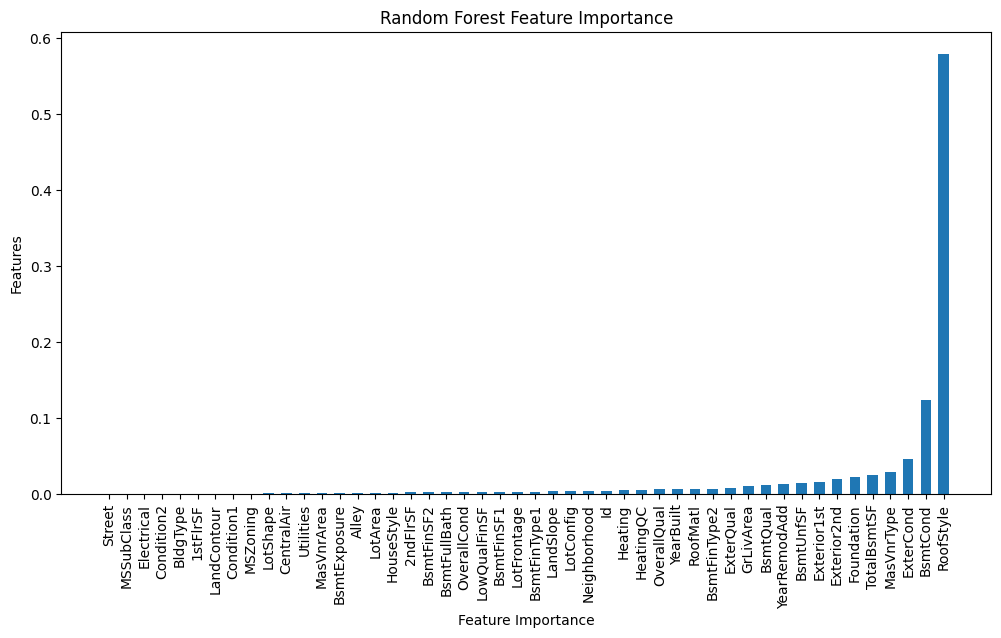

In [37]:
feature_names = list(data.columns)
feature_names.remove('SalePrice')
sorted_indices = np.argsort(importance_scores)
sorted_scores = importance_scores[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(12, 6))

plt.bar(range(len(importance_scores)), sorted_scores, tick_label=sorted_feature_names, width = 0.6)
plt.xlabel('Feature Importance')
plt.xticks(rotation = 90)
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

## Performance Evaluations Table

|Name|Training|Testing|
|----|---------|------|
|Simple Linear Regression|01%|02%|
|Multiple Linear Regression|86%|64%|
|Polynomial Regression|08%|10%|
|Decision Trees|64%|61%|
|Random Forest|98%|83%|